In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error as MSE

from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.initializers import Zeros
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


In [3]:
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.initializers import Zeros

## Loading the data

In [4]:
df = pd.read_excel('Sales.xlsx')
df.columns = ['Date','Sales']
df.head()

,Date,Sales
0,2016-07-03,395
1,2016-07-04,765
2,2016-07-05,829
3,2016-07-06,835
4,2016-07-07,1108


## Data Description & Visualization

In [5]:
df.tail(10)

,Date,Sales
147,2016-11-27,467
148,2016-11-28,520
149,2016-11-29,616
150,2016-11-30,551
151,2016-12-01,642
152,2016-12-02,296
153,2016-12-03,137
154,2016-12-04,88
155,2016-12-05,66
156,2016-12-06,5


In [6]:
df  = df.iloc[:152,:]

In [7]:
df =df.set_index('Date')

In [8]:
df.describe()

,Sales
count,152.000000
mean,751.203947
std,198.582404
min,395.000000
25%,622.750000
50%,702.000000
75%,830.500000
max,1612.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2939e978>]],
      dtype=object)

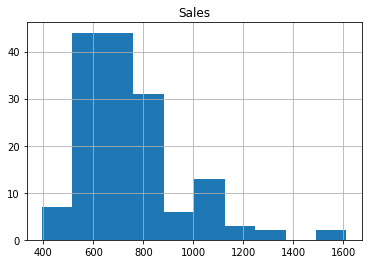

In [9]:
df.hist()

Text(0.5, 0, 'Date')

<Figure size 600x600 with 0 Axes>

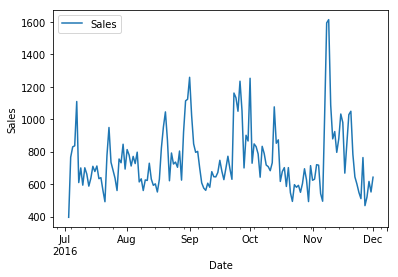

In [10]:
plt.figure(figsize = (6,6),dpi=100)
df.plot()
plt.ylabel('Sales')
plt.xlabel('Date')

##### From above histogram, Sales graph it is clear that most of the sales qualtities is between 600 and 750, with cyclic increase in sales and followed by decrease, but from above graph it can be seen that the sales remain stationary.

# Stationarity analysis

A time series is said to be stationary if its mean, variance and autocorrelation structure are constant with respect to the time-horizon of the series. In a stationary time series, recognizing patterns in the data is not affected by trends because we start by getting rid of the trend. Therefore, it is easier to forecast a stationary time series than a non-stationary series.

## Evaluating stationarity

We use the Augmented Dickey-Fuller (ADF) test for testing stationarity of a transformed series. ADF tests for the null hypothesis that the series has a unit root. Consequently, after performing the hypothesis test, the indicators returned by ADF that are in our favor (those which indicate stationarity) are: 

1.A high absolute value of t-statistic (preferably higher than 1% critical value), and, <br>2. Value of 'p-value' very close to zero. 

In [11]:
# ADF test on raw data (without transformation)

df_test = adfuller(df['Sales'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                -5.910881e+00
p-value                        2.640664e-07
#Lags Used                     0.000000e+00
Number of Observations Used    1.510000e+02
Critical Value (1%)           -3.474416e+00
Critical Value (5%)           -2.880878e+00
Critical Value (10%)          -2.577081e+00
dtype: float64


#### The Series already looks stationary as it rejects null hypothesis, but I want to try first order differencing, as it is common transformation practice

In [26]:
decomposition = seasonal_decompose(df['Sales'])

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid


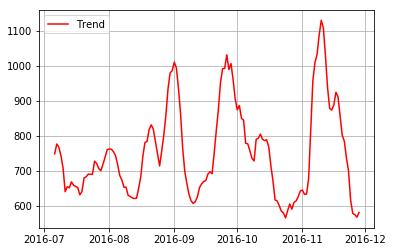

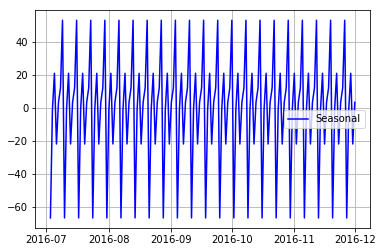

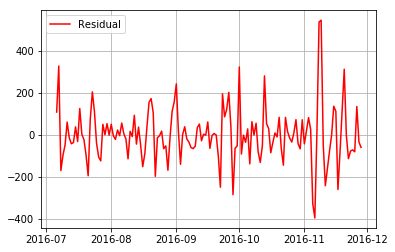

In [27]:
plt.plot(trend,color='red',label='Trend')
plt.legend()
plt.grid()
plt.show()

plt.plot(seasonal,color='Blue',label='Seasonal')
plt.legend()
plt.grid()
plt.show()

plt.plot(resid,color='red',label='Residual')
plt.legend()
plt.grid()
plt.show()

In [31]:
# Perform ADT
resid.dropna(inplace=True)
df_test_resid = adfuller(resid, autolag='AIC')
result_resid = pd.Series(df_test_resid[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_resid[4].items():
    result_resid['Critical Value (%s)'%key] = value
print (result_resid)

Test Statistic                -8.470598e+00
p-value                        1.481304e-13
#Lags Used                     8.000000e+00
Number of Observations Used    1.370000e+02
Critical Value (1%)           -3.479007e+00
Critical Value (5%)           -2.882878e+00
Critical Value (10%)          -2.578149e+00
dtype: float64


#### Residuals rejects null hypothesis

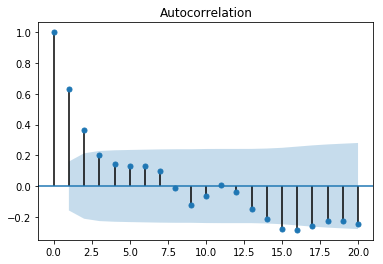

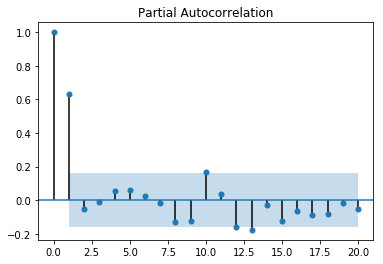

In [32]:
plot_acf(df['Sales'],lags=20)
plt.show()

plot_pacf(df['Sales'],lags=20)
plt.show()

In this case, both ACF and PACF cut-off after the first lag. There is no rigid indication of the orders p and q as required by ARIMA. The closest contenders are ARIMA(2,1,0) and ARIMA(2,0,1). We shall analyze both of these methods.

In [28]:
data1 = df['Sales'].values
train = list(data1[0:134])
train_ = list(data1[0:134])
test = list(data1[134:])
otest = list(data1[134:0])

train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(2,0,1))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(test[t]))

In [29]:
model = ARIMA(np.array(train),order=(2,0,1))
fit = model.fit()
full_predictions=list(fit.forecast(34)[0])

Mean squared error: 22227.962337


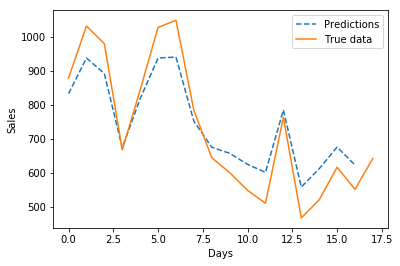

In [30]:
plt.plot(predictions[1:],'--',label='Predictions')
plt.plot(test,label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('Sales')
plt.xlabel('Days')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(test,predictions)))

Mean squared error: 64979.353473


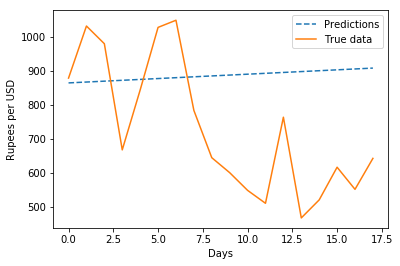

In [35]:
data1 = df['Sales'].values
train = list(data1[0:134])
train_ = list(data1[0:134])
test = list(data1[134:])
otest = list(data1[134:0])
train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(2,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(forecast))

predictions = fit.forecast(len(test))[0]
plt.plot(predictions,'--',label='Predictions')
plt.plot(test,label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('Rupees per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(test,predictions)))

### Feedforward Neural Network (FNN)
The code itself is adopted from https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/Time%20Series%20Prediction.ipynb 
The RNN is adjusted to suit as per requirement.

In [37]:
data1 = df['Sales'].values
train = list(data1[0:134])
test = list(data1[134:])

In [38]:
def gen_XY(t_list,size):
    '''
    Generates an autoregressive lagged array.
    
    Parameters
    ----------
    1. t_list: (list) Data to generate an autoregressive array out of.
    2. size: (int) Number of lagged values to consider.
    
    Returns
    ----------
    1. X: (np.ndarray) Autoregressive feature array.
    2. Y.T: (np.ndarray) Column array with values of response variable.
    
    '''
    X = np.zeros([1,size])
    Y = []
    temp_list=[]
    for i in range(len(t_list)-size):
        add_list = t_list[i:i+size]
        target = t_list[i+size]
        X = np.append(X,np.array([add_list]),axis=0)
        Y.append(target)

    X = np.delete(X,0,axis=0)
    Y = np.array(Y)

    return X,Y.T

In [39]:
X_train,y_train = gen_XY(train,1)
X_test,y_test = gen_XY(test,1)

In [40]:
X_train.shape,y_train.shape

((133, 1), (133,))

### 1 Hidden Layers with 1 neuron and relu activation function

In [41]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
133/133 [==============================] - 0s 1ms/sample - loss: 611717.3759
Epoch 2/20
133/133 [==============================] - 0s 157us/sample - loss: 611717.3769
Epoch 3/20
133/133 [==============================] - 0s 187us/sample - loss: 611717.3759
Epoch 4/20
133/133 [==============================] - 0s 172us/sample - loss: 611717.3769
Epoch 5/20
133/133 [==============================] - 0s 175us/sample - loss: 611717.3759
Epoch 6/20
133/133 [==============================] - 0s 176us/sample - loss: 611717.3759
Epoch 7/20
133/133 [==============================] - 0s 172us/sample - loss: 611717.3759
Epoch 8/20
133/133 [==============================] - 0s 175us/sample - loss: 611717.3750
Epoch 9/20
133/133 [==============================] - 0s 184us/sample - loss: 611717.3764
Epoch 10/20
133/133 [===

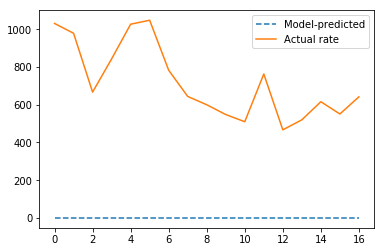

MSE: 555534.176471


In [42]:
y_pred  =  model.predict(X_test)
plt.plot(y_pred,'--',label='Model-predicted')
plt.plot(y_test,label='Actual rate')
plt.legend()
plt.show()
print('MSE: %f'%(MSE(y_test,y_pred)))

### 2 Hidden Layers with 50 neurons each and ReLU activation function

In [43]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
133/133 [==============================] - 0s 2ms/sample - loss: 84143.4478
Epoch 2/30
133/133 [==============================] - 0s 75us/sample - loss: 30959.9243
Epoch 3/30
133/133 [==============================] - 0s 80us/sample - loss: 43447.9512
Epoch 4/30
133/133 [==============================] - 0s 75us/sample - loss: 31551.1581
Epoch 5/30
133/133 [==============================] - 0s 72us/sample - loss: 28816.3772
Epoch 6/30
133/133 [==============================] - 0s 81us/sample - loss: 29511.5405
Epoch 7/30
133/133 [==============================] - 0s 68us/sample - loss: 28400.2390
Epoch 8/30
133/133 [==============================] - 0s 77us/sample - loss: 29201.5313
Epoch 9/30
133/133 [==============================] - 0s 70us/sample - loss: 29083.3124
Epoch 10/30
133/133 [==============================] - 0s 68us/sample - loss: 28763.0419
Epoch 11/30
133/133 [==============================] - 0s 73us/sample - loss: 28713.6508
Epoch 12/30
133/133 [==========

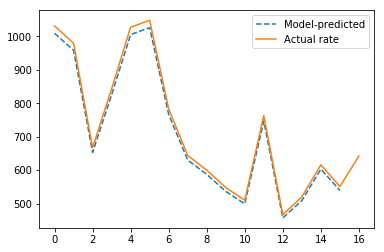

MSE: 26320.697937


In [44]:
y_pred  =  model.predict(X_test)
plt.plot(y_pred[1:],'--',label='Model-predicted')
plt.plot(y_test,label='Actual rate')
plt.legend()
plt.show()
print('MSE: %f'%(MSE(y_test, y_pred)))

#### 4 Hidden Layers with 100 neurons each and ReLU activation function

In [45]:
K.clear_session()
model = Sequential()
model.add(Dense(100, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(100, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(100, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(100, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
133/133 [==============================] - 0s 3ms/sample - loss: 155901.2442
Epoch 2/20
133/133 [==============================] - 0s 156us/sample - loss: 45330.6523
Epoch 3/20
133/133 [==============================] - 0s 150us/sample - loss: 36167.1506
Epoch 4/20
133/133 [==============================] - 0s 149us/sample - loss: 31412.0935
Epoch 5/20
133/133 [==============================] - 0s 149us/sample - loss: 28591.7196
Epoch 6/20
133/133 [==============================] - 0s 154us/sample - loss: 30540.2758
Epoch 7/20
133/133 [==============================] - 0s 149us/sample - loss: 28655.8157
Epoch 8/20
133/133 [==============================] - 0s 152us/sample - loss: 28817.4482
Epoch 9/20
133/133 [==============================] - 0s 152us/sample - loss: 29219.0127
Epoch 10/20
133/133 [==============================] - 0s 149us/sample - loss: 29801.8933
Epoch 11/20
133/133 [==============================] - 0s 151us/sample - loss: 31435.9099
Epoch 12/20
133/133 

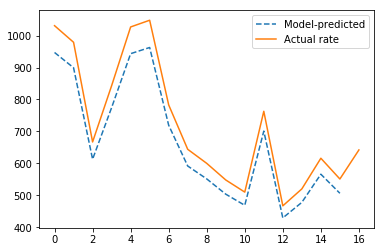

MSE: 26969.881853


In [46]:
y_pred  =  model.predict(X_test)
plt.plot(y_pred[1:],'--',label='Model-predicted')
plt.plot(y_test,label='Actual rate')
plt.legend()
plt.show()
print('MSE: %f'%(MSE(y_test, y_pred)))


In [47]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [48]:
X_tr_t.shape

(133, 1, 1)

### LSTM- Recurrent Neural Network (LSTM-RNN)

In [50]:
from tensorflow.keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(100,input_shape=(1, X_train.shape[1]), activation='relu'))
model_lstm.add(Dense(100,input_shape=(1, X_train.shape[1]), activation='relu'))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
#early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
133/133 [==============================] - 2s 11ms/sample - loss: 40385.3585
Epoch 2/200
133/133 [==============================] - 0s 4ms/sample - loss: 33081.5268
Epoch 3/200
133/133 [==============================] - 0s 3ms/sample - loss: 32746.0337
Epoch 4/200
133/133 [==============================] - 0s 4ms/sample - loss: 32427.4387
Epoch 5/200
133/133 [==============================] - 0s 3ms/sample - loss: 32054.6647
Epoch 6/200
133/133 [==============================] - 0s 3ms/sample - loss: 32300.5548
Epoch 7/200
133/133 [==============================] - 0s 3ms/sample - loss: 31809.2598
Epoch 8/200
133/133 [==============================] - 0s 3ms/sample - loss: 31614.4065
Epoch 9/200
133/133 [==============================] - 0s 3ms/sample - loss: 31515.6177
Epoch 10/200
133/133 [==============================] - 0s 3ms/sample - loss: 31417.0508
Epoch 11/200
133/133 [==============================] - 0s 3ms/sample - loss: 31338.7808
Epoch 12/200
133/133 [=======

133/133 [==============================] - 1s 4ms/sample - loss: 29423.0882
Epoch 94/200
133/133 [==============================] - 0s 4ms/sample - loss: 29654.3116
Epoch 95/200
133/133 [==============================] - 1s 4ms/sample - loss: 29540.1625
Epoch 96/200
133/133 [==============================] - 0s 4ms/sample - loss: 29489.8958
Epoch 97/200
133/133 [==============================] - 1s 4ms/sample - loss: 29461.2077
Epoch 98/200
133/133 [==============================] - 1s 4ms/sample - loss: 29440.3959
Epoch 00098: early stopping


In [52]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

print("The MSE on the Train set is:\t{:0.3f}".format(MSE(y_train, y_train_pred_lstm)))
print("The MSE on the Test set is:\t{:0.3f}".format(MSE(y_test,y_pred_test_lstm)))

The MSE on the Train set is:	28070.524
The MSE on the Test set is:	26207.491


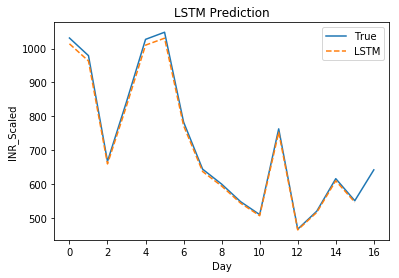

In [53]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm[1:],'--',label='LSTM')
plt.title("LSTM Prediction")
plt.xlabel('Day')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

18